Dataset Columns: ['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'delivery_time', 'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'distance', 'Time_taken(min)']

Sample data:
         ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x2318    COIMBRES13DEL01                   23                   12.54   
1  0x3474     BANGRES15DEL01                   28                     4.6   
2  0x9420      JAPRES09DEL03                   23                     4.5   
3  0x72ee      JAPRES07DEL03                   21                     4.8   
4  0xa759     CHENRES19DEL01                   31                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            11.0036

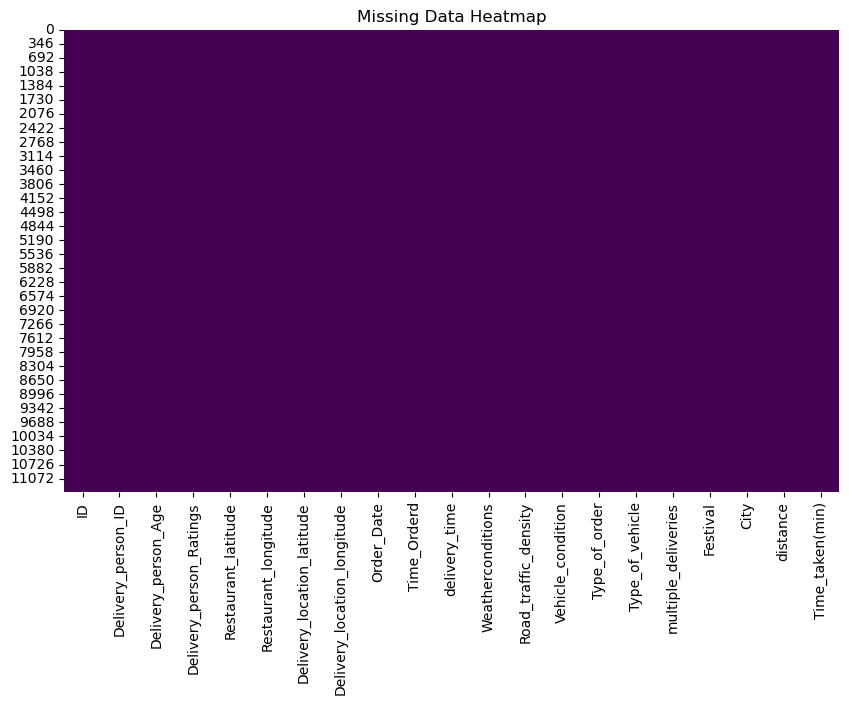


Missing values before preprocessing:
ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
delivery_time                  0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
distance                       0
Time_taken(min)                0
dtype: int64

Data after dropping rows with missing target or important columns: 11399 rows

Missing values after preprocessing:
ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaura

C:\Users\immah\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['ID' 'Delivery_person_ID' 'Order_Date' 'Type_of_order' 'Type_of_vehicle'
 'Festival' 'City']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


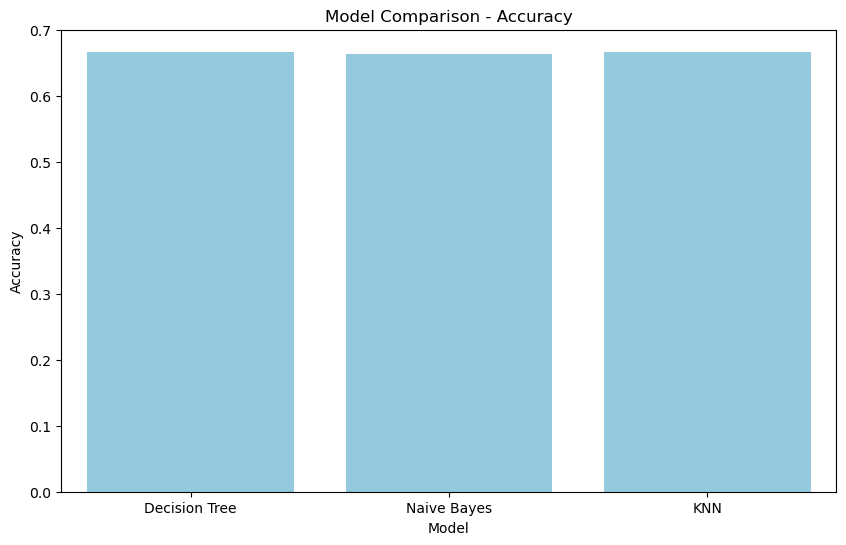

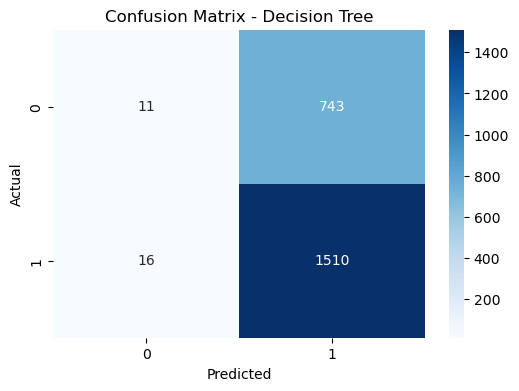

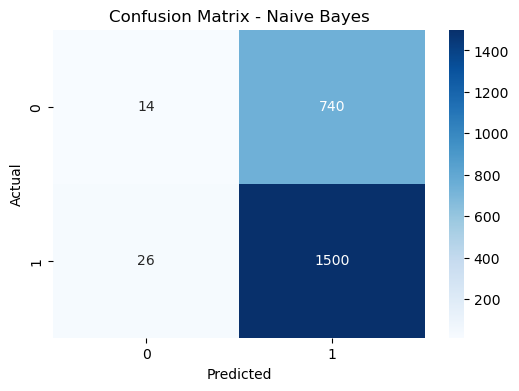

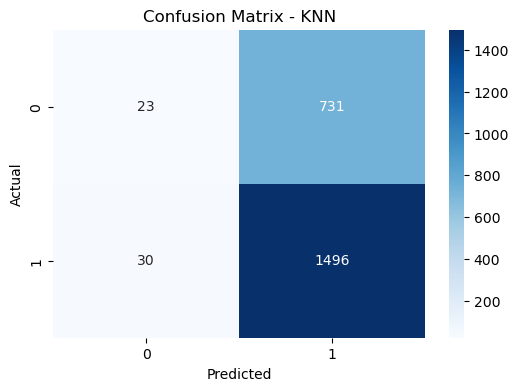

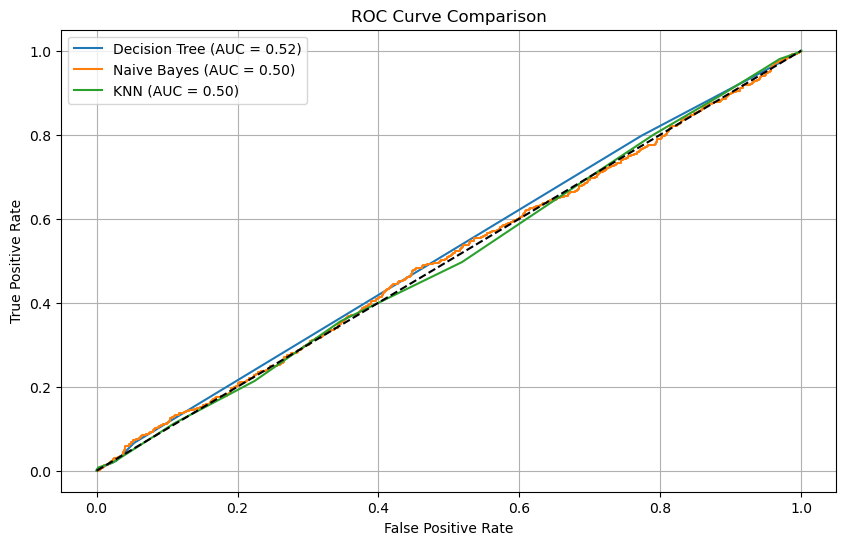

Model Evaluation Summary:

        Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
Decision Tree  0.667105   0.583306 0.667105  0.544187 0.516183
  Naive Bayes  0.664035   0.563936 0.664035  0.544826 0.503537
          KNN  0.666228   0.593117 0.666228  0.552434 0.498627

Actionable Insights:

Model: Decision Tree
 - Accuracy: 0.67
 - Precision: 0.58
 - Recall: 0.67
 - F1 Score: 0.54
 - ROC AUC: 0.52

Model: Naive Bayes
 - Accuracy: 0.66
 - Precision: 0.56
 - Recall: 0.66
 - F1 Score: 0.54
 - ROC AUC: 0.50

Model: KNN
 - Accuracy: 0.67
 - Precision: 0.59
 - Recall: 0.67
 - F1 Score: 0.55
 - ROC AUC: 0.50

Recommendation:
Based on the highest accuracy, the recommended model is: **Decision Tree**
with an accuracy of 0.67 and F1 Score of 0.54.
It also offers good interpretability via tree visualization.


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Load dataset
data = pd.read_csv('Food_Delivery_Time_Prediction.csv')
data.columns = data.columns.str.strip()

# Print actual column names
print("Dataset Columns:", data.columns.tolist())

# View sample data
print("\nSample data:\n", data.head())

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

# Check for missing values before cleaning
print("\nMissing values before preprocessing:")
print(data.isnull().sum())

# Clean and ensure dataset isn't empty after preprocessing
# Drop rows with any missing target labels or important columns
data_cleaned = data.dropna(subset=['Time_taken(min)', 'Road_traffic_density', 'Weatherconditions', 'Delivery_person_Age'])

# Ensure there's still data after dropping rows
print(f"\nData after dropping rows with missing target or important columns: {data_cleaned.shape[0]} rows")

# Convert 'distance' to numeric and fill missing with median
data_cleaned['distance'] = pd.to_numeric(data_cleaned['distance'].astype(str).str.strip(), errors='coerce')
data_cleaned['distance'].fillna(data_cleaned['distance'].median(), inplace=True)

# Clean whitespace from categorical columns
for col in ['Road_traffic_density', 'Type_of_order', 'Weather_conditions']:
    if col in data_cleaned.columns:
        data_cleaned[col] = data_cleaned[col].astype(str).str.strip()

# Extract numeric delivery time from 'Time_taken (min)'
extracted_time = data_cleaned['Time_taken(min)'].astype(str).str.extract('(\d+)')[0]
data_cleaned['delivery_time'] = pd.to_numeric(extracted_time, errors='coerce')

# Drop rows where delivery_time couldn't be converted
data_cleaned = data_cleaned[pd.to_numeric(data_cleaned['delivery_time'], errors='coerce').notnull()]

# Now apply your binary condition
data_cleaned['Delivery_Status'] = data_cleaned['delivery_time'].apply(lambda x: 1 if x < 30 else 0)

# Check again for missing values after cleaning
print("\nMissing values after preprocessing:")
print(data_cleaned.isnull().sum())

# Encode categorical features
data_log = data_cleaned.copy()
label_encoders = {}
for col in ['Road_traffic_density', 'Weatherconditions']:
    le = LabelEncoder()
    data_log[col] = le.fit_transform(data_log[col].astype(str))
    label_encoders[col] = le

# Prepare features and target
X = data_log.drop(['Delivery_Status', 'delivery_time', 'Time_taken(min)'], axis=1, errors='ignore')
y = data_log['Delivery_Status']
X = X.apply(pd.to_numeric, errors='coerce')

# Impute missing values in features if any remain
imputer = SimpleImputer(strategy='median')

# Check if any rows are left before applying imputer
if X.shape[0] > 0:
    X_imputed = imputer.fit_transform(X)
else:
    print("No rows left after preprocessing. Please check the data cleaning steps.")
    X_imputed = np.empty((0, X.shape[1]))  # Empty matrix for X_imputed

# Proceed with the rest of the pipeline if there are rows
if X_imputed.shape[0] > 0:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    # Train models
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_nb = gnb.predict(X_test)

    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, {'n_neighbors': np.arange(1, 30)}, cv=5)
    knn_cv.fit(X_train, y_train)
    y_pred_knn = knn_cv.predict(X_test)

    dt = DecisionTreeClassifier()
    dt_cv = GridSearchCV(dt, {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}, cv=5)
    dt_cv.fit(X_train, y_train)
    y_pred_dt = dt_cv.predict(X_test)

    # Store models
    models = {
        "Decision Tree": DecisionTreeClassifier(**dt_cv.best_params_),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
    }

    # Evaluate and collect metrics
    results = {
        "Model": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": [],
        "ROC AUC": [],
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy_score(y_test, y_pred))
        results['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
        results['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
        results['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
        else:
            results['ROC AUC'].append(np.nan)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue')
    plt.title('Model Comparison - Accuracy')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot confusion matrices
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print evaluation results
    print("Model Evaluation Summary:\n")
    print(results_df.to_string(index=False))

    # Actionable insights
    print("\nActionable Insights:")
    for _, row in results_df.iterrows():
        print(f"\nModel: {row['Model']}")
        print(f" - Accuracy: {row['Accuracy']:.2f}")
        print(f" - Precision: {row['Precision']:.2f}")
        print(f" - Recall: {row['Recall']:.2f}")
        print(f" - F1 Score: {row['F1 Score']:.2f}")
        if not pd.isna(row['ROC AUC']):
            print(f" - ROC AUC: {row['ROC AUC']:.2f}")
        else:
            print(" - ROC AUC: Not available")

    # Recommend best model
    best_model_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
    print("\nRecommendation:")
    print(f"Based on the highest accuracy, the recommended model is: **{best_model_row['Model']}**")
    print(f"with an accuracy of {best_model_row['Accuracy']:.2f} and F1 Score of {best_model_row['F1 Score']:.2f}.")

    if best_model_row['Model'] == 'Decision Tree':
        print("It also offers good interpretability via tree visualization.")
    elif best_model_row['Model'] == 'Naive Bayes':
        print("This model is simple and interpretable but may underperform with feature dependency.")
    elif best_model_row['Model'] == 'KNN':
        print("KNN is easy to understand but less interpretable in high dimensions and slower on large datasets.")
else:
    print("Skipping model training due to empty dataset.")
